# 3. Preparado de los Datos
A lo largo de este notebook se cubre la tercera fase de la metodología CRIPS-DM, en este caso la preparación dec los datos

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. <span style="color:#66FF99;">**Preparación de los Datos (Data Preparation)** </span> 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. **Modelado (Modeling)**  
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.



Con los datos seleccionados del conjunto de datos, pasamos a generar nuevos datos adicionales que nos permitan entrenar el modelo con una cuantia de datos aun mayor dadas las clases seleccionadas, además de extraer nuevas características de nuestras imágemes para obtener mejores resultados con los modelos a usar. Es por ello que este apartado se divide en dos etapas:

1. Muestreado y preprocesamiento de las imágenes

2. Generación de imágenes derivadas de las actuales y desarrolo de técnicas de data augmentation


### 1. Sampleado del conjunto de datos

Este primer apartado abarca la corrección de aquellas deficiencias enconrtadas a lo largo del notebook anterior, relativo al análisis exploratorio de los datos.

A lo largo de esta primera parte del noteobook se procederá a la realización del sampleo de instancias del dataset inicial, dando como salida en este caso un dataset nativo de tensorflow `tf.dataset`, que permitirá que el entrenamierto del modelo sea lo más rápido posible. Los objetivos de este apartado serán varios:

- La eliminación las máscaras demasiado pequeñas, para facilitar el aprendijaze del modelo.

- Elimimnación de instancias con únicamente fondo

- La obtención de  un conjunto de entrenamieto más balanceado.

In [64]:
from pathlib import Path
from utils import  load_yaml_file, download_zip
import os

import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import numpy as np
import random

import tensorflow as tf

import matplotlib.patches as mpatches

from tqdm import tqdm


from pycocotools.coco import COCO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os


import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

from utils import mask_generator_one_hot, plot_one_hot_encoded_masks, mask_generator, plot_image_and_mask

In [3]:
yaml = load_yaml_file()


objetives = yaml["objetive_classes"]


N_CLASSES = len(objetives) + 1

In [4]:
DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=24.92s)
creating index...
index created!


In [5]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"
categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}


dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}
mapper_indexModel_index_result = {value:i for i, value in enumerate(sorted(category_info_objetive.keys()))}


In [79]:
dict_channel_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}
dict_channel_name

{0: 'background',
 1: 'person',
 2: 'car',
 3: 'motorcycle',
 4: 'bus',
 5: 'traffic light',
 6: 'backpack',
 7: 'handbag',
 8: 'chair',
 9: 'dining table',
 10: 'cell phone'}

En primer lugar se descartan todas aquellas muestras que no contengan clases objetivo, conteniendo unicamente fondo. 

In [6]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las imagenes con las clases coindicentes son  {len(img_ids)}")

Las imagenes con las clases coindicentes son  79542


Del conjunto que contienen al menos una clase, definimos un umbral minimo y vemos si la suma de pixeles que supone la totalidad de las máscaras es o no significativa para nuestro conjunto de entrenamiento

Se define una función que, usando la API de COCO genere un `np.array` de la instancia, que alimentará el `tf.dataset`.
Antes del guardado definitivo, se generan funciones que permitan visualizar la correcta generación de las máscaras

In [18]:
img, mask = mask_generator_one_hot(coco, image_id= img_ids[0], path_images = DIR_TRAIN_IMGS, ids_masks = id_objetives)

Además, se genera una función que genera de una imagen la clase `fondo`, aquella que se corresponderá con cada uno de los píxeles no etiquetados en la imagen, y que permitirá entrenar el modelo de forma correcta.

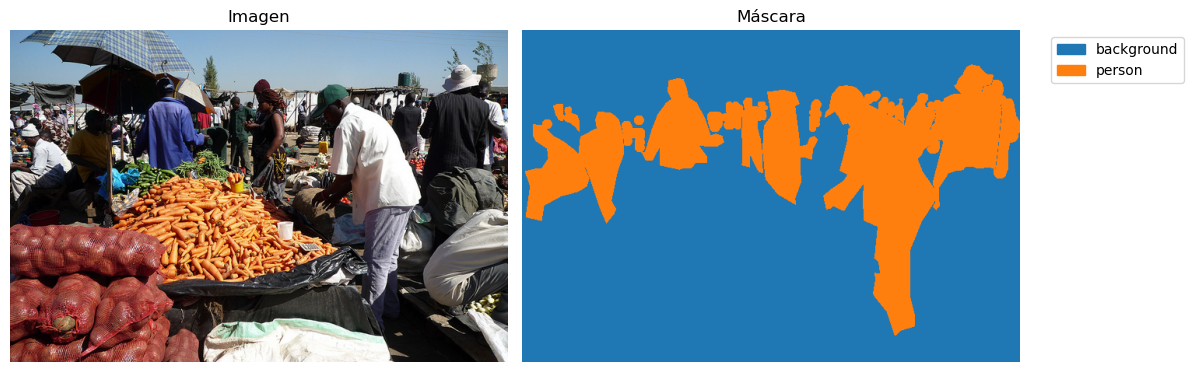

In [32]:
plot_one_hot_encoded_masks(img, mask, category_info_objetive)

Comprobados los resultados, generamos el objeto `tf.dataset` que nos permitirá una carga más rápida en memoria a la hora de entrenar nuetro modelo. Además, este tipo de objetos es más portable de cara a cargarse en un entorno cloud, que podrá ser usado a futuro si se requieren mayores capacidades computacionales, al carecer de GPU.


Se decide obtener un conjunto de datos múltiplo de 16 para evitar obtener batches vacíos en el entrenamiento.

In [ ]:
tfrecord_path_train = "dataset_train_2.tfrecord"
tfrecord_path_test = "dataset_test_2.tfrecord"

batch_size = 16
total_id_images = img_ids[:batch_size*(len(img_ids)//batch_size)]

In [34]:
proportion_train_test = 0.80
n_batches_train  = round((len(total_id_images)//batch_size)*proportion_train_test)
n_batches_train

train_image_ids = random.sample(total_id_images, n_batches_train*batch_size)
test_image_ids = [item for item in total_id_images if item not in train_image_ids]

Para la generación de un dataset menos desvalanceado que el generado se ha decidido aplicar `cropping` aleatorio de máscaras que permitirán mayor presencia de las clases minoritarias en las imágenes, haciendo que tomen importancia en las métricas de error definidas para los modelos y así evitar un sobreajuste del modelo en clases mayoritarias.

En primer lugar se define una función que evitará problematicas causadas por discrepancias en las dimensiones de las imágenes, que no presentan un tamaño único.

In [ ]:
def resize_add_top_right(img, mask, target_shape):

    input_h,input_w,_= img.shape
    target_h,target_w,_= target_shape

    cropped= img[:min(input_h, target_h),:min(input_w, target_w), :]
    cropped_mask =mask[:min(input_h, target_h),:min(input_w, target_w)]

    pad_top = max(target_h-cropped.shape[0],0)
    pad_right = max(target_w-cropped.shape[1],0)

    padded = np.pad(cropped,((pad_top, 0),(0,pad_right),(0,0)),mode='constant',constant_values=0)
    padded_mask = np.pad(cropped_mask,((pad_top,0),(0,pad_right)),mode='constant',constant_values=0)

    return padded, padded_mask

A continuación se define la función que permite la inserción de una máscara de una immagen aleatoria, generando la nueva imagen y máscaras con los recortes

In [58]:
def insert_random_mask(img, mask_orig, target_class, target_channel):

    img_ids = coco.getImgIds(catIds=[target_class])
    target_id = random.choice(img_ids)
    target_info = coco.loadImgs(target_id)[0]
    target_path = os.path.join(DIR_TRAIN_IMGS, target_info['file_name'])
    target = cv2.imread(target_path)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=target_id,  catIds=[target_class],  iscrowd=False)
    anns = coco.loadAnns(ann_ids)
    ann = random.choice(anns)

    mask_target = coco.annToMask(ann)


    shape = img.shape

    target, mask_target = resize_add_top_right(target, mask_target, shape)

    bool_mask_3d = mask_target[:, :, np.newaxis]
    result_image = np.where(bool_mask_3d,target,img)

    mask_orig[mask_target.astype(bool)] = target_channel


    return result_image, mask_orig

In [59]:
CONS_N_CROPPINGS = 3

Se representa un primer ejemplo para validar el resultado:

In [151]:
id_objetives

[1, 3, 4, 6, 10, 27, 31, 77, 62, 67]

In [157]:
img, mask = mask_generator(coco, train_image_ids[0], ids_masks= id_objetives ,path_images = DIR_TRAIN_IMGS)
mask=np.vectorize(lambda x:dict_class_index.get(x, x))(mask)
img = np.array(img)
for _ in range(CONS_N_CROPPINGS):
    class_cropping = random.choice(id_objetives)
    target_channel = mapper_indexModel_index_result[class_cropping]
    img, mask = insert_random_mask(img, mask, class_cropping,target_channel )
    #print(np.unique(mask))

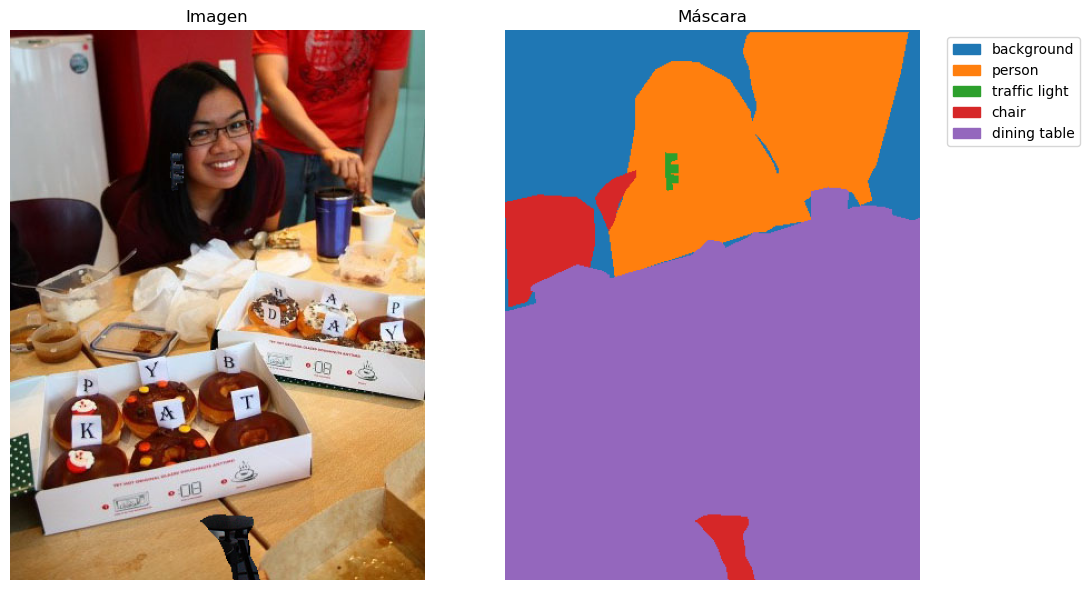

In [158]:
plot_image_and_mask(img,mask,dict_channel_name)

Se genera el dataset completo tanto de train como de test:

In [ ]:
def serialize_example(img_id, coco,path_images, id_objetives ):

    img, mask = mask_generator(coco, img_id, ids_masks= id_objetives  ,path_images = path_images)
    #print("masl", np.unique(mask))
    mask=np.vectorize(lambda x:dict_class_index.get(x, x))(mask)
    img = np.array(img)
    for _ in range(CONS_N_CROPPINGS):
        class_cropping = random.choice(id_objetives)
        target_channel = mapper_indexModel_index_result[class_cropping]
        img, mask = insert_random_mask(img, mask, class_cropping,target_channel )

    print("shae", mask.shape)
    print("masl", np.unique(mask))

    mask = np.eye(N_CLASSES)[mask]

    print()




    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_encoded = tf.io.encode_jpeg(img).numpy() 
    mask = mask.astype(np.uint8)
    mask_raw = mask.tobytes()
    mask_shape = list(mask.shape) 
   
    #mask_encoded = tf.io.encode_png(mask).numpy()  

    feature = {
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_encoded])),
        #"mask": tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_encoded]))
        "mask": tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_raw])),
        "mask_shape": tf.train.Feature(int64_list=tf.train.Int64List(value=mask_shape))
    }

    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

with tf.io.TFRecordWriter(tfrecord_path_train) as writer:
    for img_id in tqdm(train_image_ids, desc="Generando Conjunto de datos Train"):
        example = serialize_example(img_id,coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

with tf.io.TFRecordWriter(tfrecord_path_test) as writer:
    for img_id in tqdm(test_image_ids, desc="Generando Conjunto de datos Test"):
        example = serialize_example(img_id, coco,DIR_TRAIN_IMGS, id_objetives)
        writer.write(example)

Generando Conjunto de datos Train:   0%|          | 0/63632 [00:00<?, ?it/s]

shae (495, 373)
masl [0 1 4 8 9]



InvalidArgumentError: {{function_node __wrapped__EncodePng_device_/job:localhost/replica:0/task:0/device:CPU:0}} image must have 1, 2, 3, or 4 channels, got 11 [Op:EncodePng] name: 

In [ ]:
def parse_tfrecord(example_proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    img = tf.io.decode_jpeg(example["image"]) 
    img = tf.image.convert_image_dtype(img, tf.float32)  
 
    mask = tf.io.decode_png(example["mask"], channels=0) 
    
    return img, mask


In [ ]:

dataset = tf.data.TFRecordDataset(tfrecord_path_train)
dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.padded_batch(
    batch_size=16, 
    padding_values=(tf.constant(0.0, dtype=tf.float32), 
                    tf.constant(0, dtype=tf.uint8)),    
    padded_shapes=([None, None, 3], [None, None, N_CLASSES])
)

dataset = dataset.prefetch(tf.data.AUTOTUNE)


for batch in dataset.take(1):
    print(batch[0].shape, batch[1].shape)  

## 2. Data augmentation

A continuación, se define la fase de data augmentation a aplicar al conjunto de datos para el entrenamiento del modelo.
En este caso, las transformaciones a aplicar serán las siguientes:





In [ ]:
def augment_data(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.85:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    # if tf.random.uniform(()) > 0.5:
    #     image = tf.image.flip_up_down(image)
    #     mask = tf.image.flip_up_down(mask)

    # Random rotation (90 degrees increments)
    if tf.random.uniform(()) > 0.95:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)
        mask = tf.image.rot90(mask, k)

    # Random brightness adjustment
    if tf.random.uniform(()) > 0.85:
        image = tf.image.adjust_brightness(image, delta=tf.random.uniform([], -0.1, 0.1))

    # Random contrast adjustment
    if tf.random.uniform(()) > 0.85:
        image = tf.image.adjust_contrast(image, contrast_factor=tf.random.uniform([], 0.9, 1.1))

    # Random Gaussian noise
    if tf.random.uniform(()) > 0.85:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # # Random zoom (cropping and resizing)
    # if tf.random.uniform(()) > 0.95:
    #     scale = tf.random.uniform([], 0.8, 1.2)
    #     original_size = tf.shape(image)[:2] 
    #     new_size = tf.cast(tf.cast(original_size, tf.float32) * scale, tf.int32) 
    #     image = tf.image.resize(image, new_size)
    #     mask = tf.image.resize(mask, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #     image = tf.image.resize_with_crop_or_pad(image, tf.shape(image)[0], tf.shape(image)[1])
    #     mask = tf.image.resize_with_crop_or_pad(mask, tf.shape(mask)[0], tf.shape(mask)[1])

    return image, mask